# DO NOT MODIFY THIS NOTEBOOK

This was made using a modified version of the ART code, where the HN fraction can be set from the outside. This is no longer possible, so this code will not run. 

However, it is easy to add. Simply add a hn_fraction parameter to the `get_ejecta_sn_ii_py` function, and propagate it accordingly. Some of the code used to compile the python wrapper will need to be changed slightly, but that's not too difficult

In [1]:
from collections import defaultdict
import numpy as np
import tabulation
from tabulation import Lifetimes
from tabulation import IMF
from scipy import integrate
from tqdm.notebook import tqdm
from scipy import optimize, interpolate
import cmocean
from matplotlib import colors as mpl_colors
from matplotlib import cm
from astropy import table
from astropy import units as u

import betterplotlib as bpl
bpl.set_style()

In [2]:
import sys, os
sys.path.append(os.path.abspath("../../build/"))

In [3]:
from core_enrich_ia_elts_cluster_discrete import lib as core
from snii_enrich_ia_elts_cluster_discrete import lib as snii
from snii_enrich_ia_elts_cluster          import lib as snii_c

In [4]:
core.detailed_enrichment_init()
snii.detailed_enrichment_init()
snii.init_rand()

snii_c.detailed_enrichment_init()
snii_c.init_rand()

In [5]:
lt = Lifetimes("Raiteri_96")
imf = IMF("Kroupa", 0.08, 50, total_mass=1)

# generate history

In [6]:
dt_sn = 1E3

In [7]:
def ceil_to_nearest(num, scale):
    test_values = np.arange(0, num+2*scale, scale)
    for val in test_values:
        if val - scale > num:
            return val

In [8]:
times = dict()
turnoff_masses = dict()
def generate_times(zs):
    for z in zs:
        times[z] = np.arange(lt.lifetime(50.0, z), 50e6, dt_sn)
        turnoff_masses[z] = [lt.turnoff_mass(t, z) for t in tqdm(times[z])]

Find the metallicities with a given HN fraction

In [9]:
generate_times([0.02])

In [10]:
elts = ["C", "N", "O", "Mg", "S", "Ca", "Fe"]
all_fields = elts + ["Z_II", "Z_Ia", "Z_AGB", "Z", "total", "E", "N_SN", "N_SN_left"]
sn_ii_idxs = {"C": 0, "N": 1, "O":2, "Mg":3, "S":4, "Ca": 5, "Fe": 6,
              "Z_II": 7, "Z": 7, "total": 8, "E": 9, "N_SN": 10, "N_SN_left": 11}

class SNHistory(object):
    def __init__(self, stellar_mass, z, hn_fraction):
        self.hn_fraction = hn_fraction
        
        self.mass = stellar_mass
        self.z = z
        
        self.age_50 = lt.lifetime(50.0, self.z)
        
        self.times = times[z]
        self.turnoff_masses = turnoff_masses[z]
        
        
        self.sn_ii_func = snii.get_ejecta_sn_ii_py
        self.sn_iic_func = snii_c.get_ejecta_sn_ii_py
        
        self.yields_sn_ii = defaultdict(list)
        self.cumulative_sn_ii = defaultdict(list)
        
        self.yields_sn_iic = defaultdict(list)
        self.cumulative_sn_iic = defaultdict(list)

        self.handle_history()
        
    def handle_history(self, verbose=False):
        self.unexploded_sn_ii = 0
        self.unexploded_sn_ia = 0
        
        for idx in tqdm(range(len(self.turnoff_masses) - 1)):
            m_now  = self.turnoff_masses[idx]
            m_next = self.turnoff_masses[idx+1]
            age_now = self.times[idx]
            age_next = self.times[idx+1]
            dt = age_next - age_now
            sn_ii_yields = self.sn_ii_func(self.unexploded_sn_ii, m_now, m_next, self.mass, self.z, self.hn_fraction)
            sn_iic_yields = self.sn_iic_func(0, m_now, m_next, self.mass, self.z, self.hn_fraction)
            
            self.unexploded_sn_ii = sn_ii_yields[sn_ii_idxs["N_SN_left"]]
            
            for field in all_fields:
                if field in sn_ii_idxs:
                    this_sn_ii_yield = sn_ii_yields[sn_ii_idxs[field]]
                    this_sn_iic_yield = sn_iic_yields[sn_ii_idxs[field]]
                else:
                    this_sn_ii_yield = 0
                    this_sn_iic_yield = 0
                    
                self.yields_sn_ii[field].append(this_sn_ii_yield)
                self.yields_sn_iic[field].append(this_sn_iic_yield)
                    
                if len(self.cumulative_sn_ii[field]) == 0:
                    self.cumulative_sn_ii[field].append(this_sn_ii_yield)
                    self.cumulative_sn_iic[field].append(this_sn_iic_yield)
                else:
                    self.cumulative_sn_ii[field].append(self.cumulative_sn_ii[field][-1] + this_sn_ii_yield)
                    self.cumulative_sn_iic[field].append(self.cumulative_sn_iic[field][-1] + this_sn_iic_yield)

In [11]:
mass = 1e6

hn_fractions = [0.0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
histories = {f: SNHistory(mass, 0.02, f) for f in hn_fractions}

# HN fraction

In [12]:
# fig, ax = bpl.subplots()
# z_raw = np.logspace(-6, np.log10(0.02), 100)
# z_plot = np.log10(z_raw / 0.02)

# hn_fraction = [snii_continuous.get_hn_fraction_py(z) for z in z_raw]

# ax.plot(z_plot, hn_fraction)
# ax.add_labels("log(Z/$Z_{\odot}$)", "HN Fraction")
# ax.set_limits(-4, 0, 0, 0.6)
# fig.savefig("hn_fraction_new.png", bbox_inches="tight")

# Plot energy

In [13]:
old_sn_low = 3E6
old_sn_high = 1.5E7 + 3E6
# Normalize the start time to be the same as t
old_number_snii = integrate.quad(imf.normalized_dn_dm, 8.0, 40.0)[0]  # calculated the same way

def old_sn_rate(age, cluster_mass=1):
    if age < old_sn_low:
        return 0
    if age > old_sn_high:
        return 0
    
    phi_per_dt = 1.0 / age
    rate = phi_per_dt * cluster_mass * old_number_snii
    return rate

def old_sn_energies(age, cluster_mass=1):
    return 1E51 * old_sn_rate(age, cluster_mass)

In [14]:
old_ages = np.arange(0, 45E6, dt_sn)
offset_old_ages = old_ages - old_sn_low
old_e_rates = [old_sn_energies(a, mass) for a in old_ages]
old_e_per_timestep = [old_e_rate * dt_sn for old_e_rate in old_e_rates]
old_e_cum = integrate.cumtrapz(x=old_ages, y=old_e_rates, initial=0) / (1E49 * mass)

In [15]:
cmap = bpl.cm.lajolla
norm = mpl_colors.Normalize(vmin=-0.1, vmax=0.6)
hn_mappable = cm.ScalarMappable(norm, cmap)
def f_color(hn_fraction):
    return hn_mappable.to_rgba(hn_fraction)

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
<ipython-input-16-6ef7044d2321>:19: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig("hn_fraction_energy_dependence.png", bbox_inches="tight")
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
/Users/gillenb/miniconda3/envs/general/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


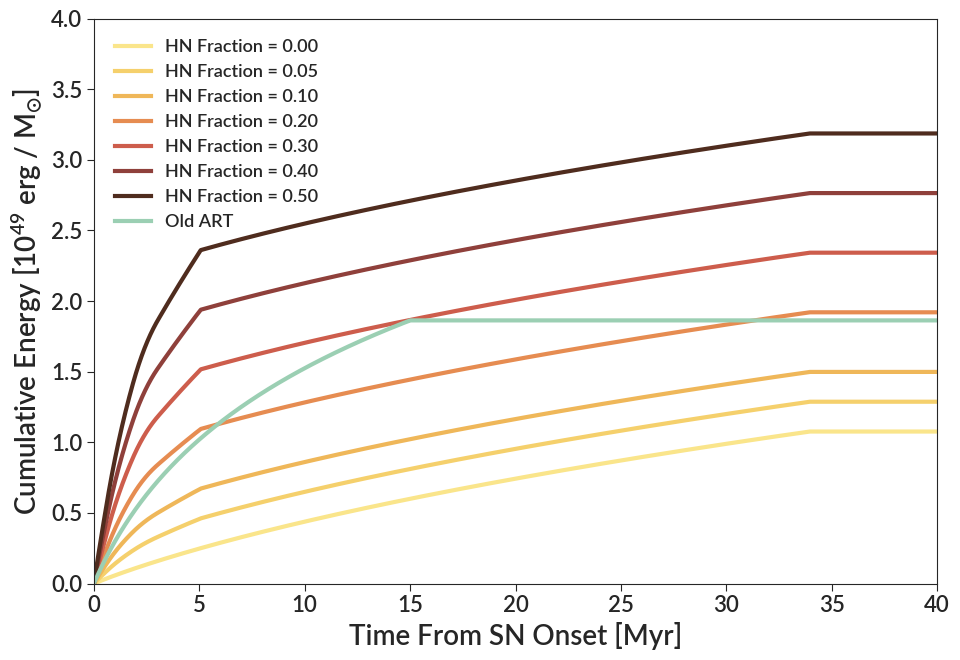

In [16]:
fig, ax = bpl.subplots()
for f in hn_fractions:
    plot_times = times[0.02][1:] - lt.lifetime(50.0, 0.02)
    
    ax.add_labels("Time From SN Onset [Myr]", "Cumulative Energy [10$^{49}$ erg / $M_{\odot}$]")

    this_obj = histories[f]
    ax.plot(plot_times / 1E6, 
            np.array(this_obj.cumulative_sn_iic["E"]) / (1E49 * mass), 
            c=f_color(f),
            label=f"HN Fraction = {f:.2f}")

ax.plot(offset_old_ages/1E6, old_e_cum, c=bpl.color_cycle[1], label="Old ART")

ax.legend(frameon=False, fontsize=13)

ax.set_limits(0, 40, 0, 4)

fig.savefig("hn_fraction_energy_dependence.png", bbox_inches="tight")

/Users/gillenb/miniconda3/envs/general/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


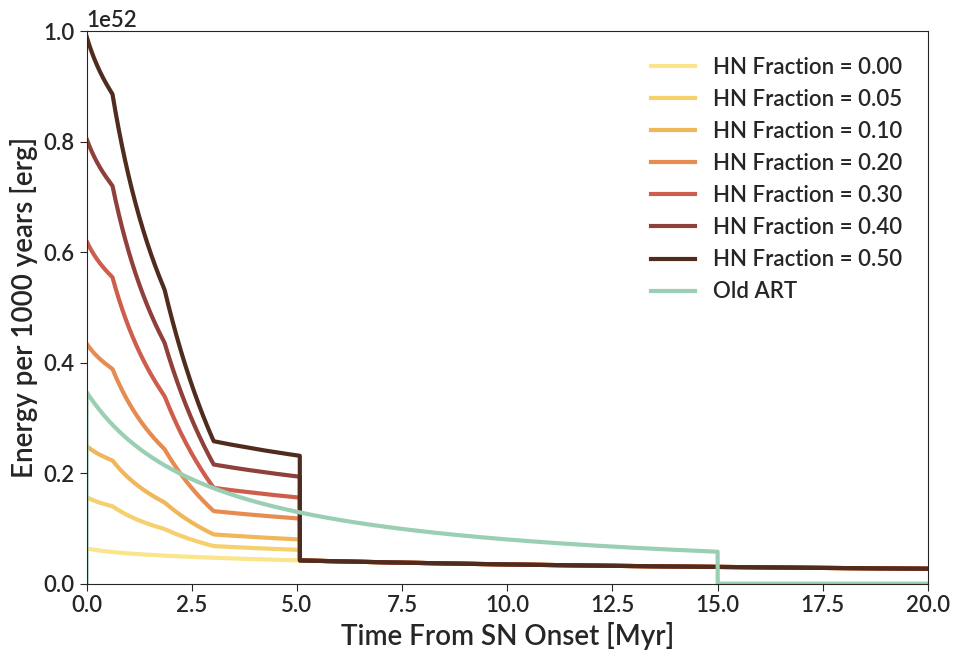

In [17]:
fig, ax = bpl.subplots()
for f in hn_fractions:
    plot_times = times[0.02][1:] - lt.lifetime(50.0, 0.02)
    
    ax.add_labels("Time From SN Onset [Myr]", "Energy per 1000 years [erg]")

    this_obj = histories[f]
    ax.plot(plot_times / 1E6, 
            np.array(this_obj.yields_sn_iic["E"]), 
            c=f_color(f),
            label=f"HN Fraction = {f:.2f}")

ax.plot(offset_old_ages/1E6, old_e_per_timestep, c=bpl.color_cycle[1], label="Old ART")

ax.legend(frameon=False, fontsize=16)

ax.set_limits(0, 20, 0, 1e52)

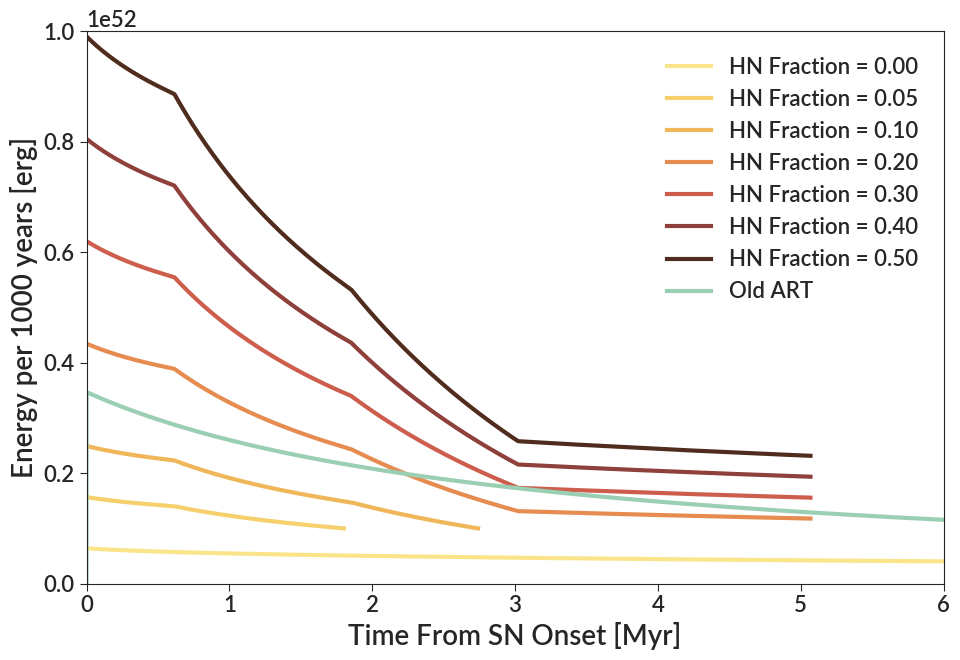

In [18]:
fig, ax = bpl.subplots()
for f in hn_fractions:
    plot_times = times[0.02][1:] - lt.lifetime(50.0, 0.02)
    
    ax.add_labels("Time From SN Onset [Myr]", "Energy per 1000 years [erg]")

    this_obj = histories[f]
    
    # get timesteps where HN happen
    this_y = np.array(this_obj.yields_sn_iic["E"])
    if f > 0:
        hn_mask = this_y > 1e51
    else:
        hn_mask = this_y > 0

    ax.plot(plot_times[hn_mask] / 1E6, 
            this_y[hn_mask], 
            c=f_color(f),
            label=f"HN Fraction = {f:.2f}")

ax.plot(offset_old_ages/1E6, old_e_per_timestep, c=bpl.color_cycle[1], label="Old ART")

ax.legend(frameon=False, fontsize=16)

ax.set_limits(0, 6, 0, 1e52)

## then calculate the relative energy

In [24]:
interps = dict()
for f in hn_fractions:
    x=(times[0.02][1:] - lt.lifetime(50.0, 0.02))/1e6
    y=np.array(histories[f].yields_sn_ii["E"])
    
    if f > 0:
        hn_mask = y > 1e51
    else:
        hn_mask = y > 0

    interps[f] = interpolate.interp1d(x=x[hn_mask], 
                                   y=y[hn_mask], 
                                   kind="linear", bounds_error=False, fill_value=0)

interps["Old ART"] = interpolate.interp1d(y=old_e_per_timestep, 
                                      x=offset_old_ages/1E6, 
                                      kind="linear", bounds_error=False, fill_value=0)

In [25]:
xs = np.arange(0, 30, 1e3/1e6)
rel_interps = {f: interps[f](xs) / interps[0.0](xs) for f in interps}

<ipython-input-25-634c719d62d8>:2: RuntimeWarning: invalid value encountered in true_divide
  rel_interps = {f: interps[f](xs) / interps[0.0](xs) for f in interps}
<ipython-input-25-634c719d62d8>:2: RuntimeWarning: divide by zero encountered in true_divide
  rel_interps = {f: interps[f](xs) / interps[0.0](xs) for f in interps}


/Users/gillenb/miniconda3/envs/general/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


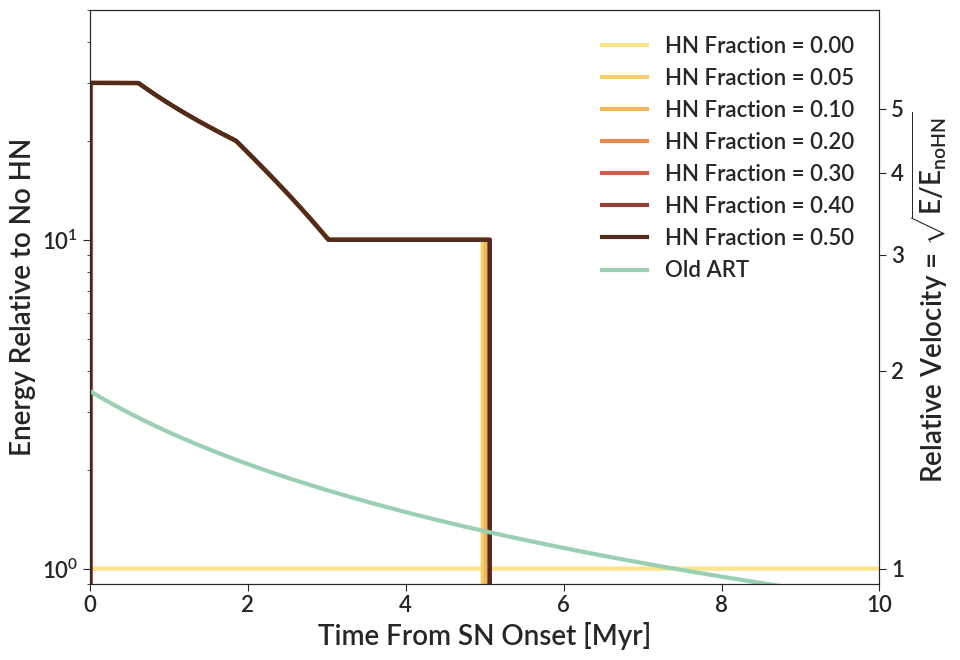

In [27]:
fig, ax = bpl.subplots()
for f in rel_interps:
    if f == "Old ART":
        c = bpl.color_cycle[1]
        label = "Old ART"
    else:
        c = f_color(f)
        label = f"HN Fraction = {f:.2f}"
    ax.plot(xs, 
            rel_interps[f], 
            c=c,
            label=label)

ax.add_labels("Time From SN Onset [Myr]", "Energy Relative to No HN")
ax.legend(frameon=False, fontsize=16)
ax.set_yscale("log")
ax.axhline(1, ls=":", zorder=0)
ax.set_limits(0, 10, 0.9, 50)
ax.twin_axis("y", [1, 2, 3, 4, 5], label="Relative Velocity = $\sqrt{E/E_{no HN}}$", old_to_new_func=np.sqrt)



This makes sense, as the energy doesn't depend at all on the hn fraction, as HN always have the same energy.

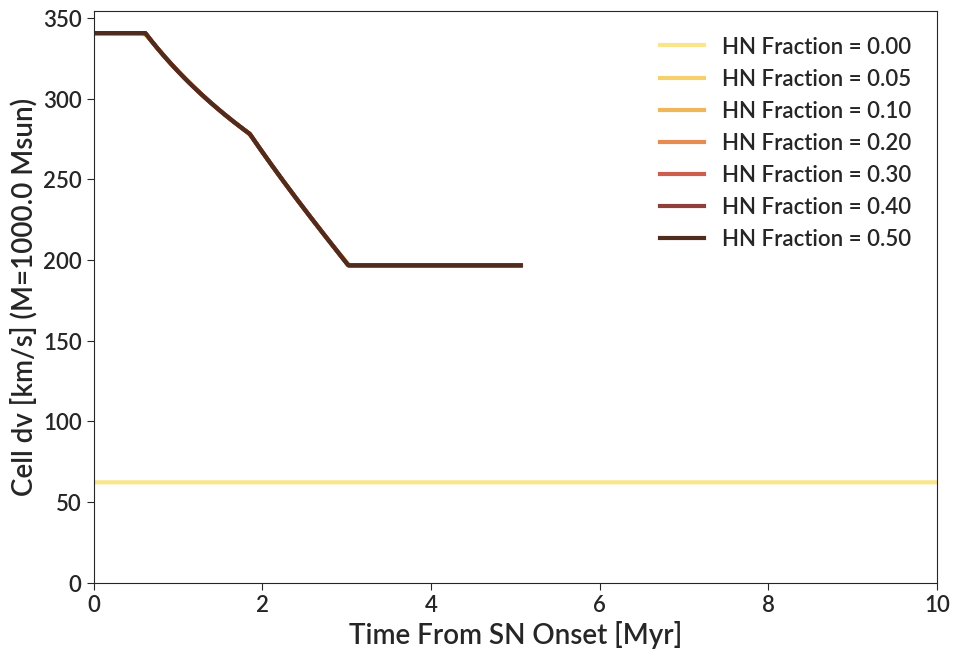

In [30]:
cell_mass = 1e3 * u.Msun

fig, ax = bpl.subplots()
for f in hn_fractions:
    plot_times = times[0.02][1:] - lt.lifetime(50.0, 0.02)
    
    this_obj = histories[f]
    
    total_E = np.array(this_obj.yields_sn_ii["E"]) * u.erg
    
    if f > 0:
        hn_mask = total_E > 1e51 * u.erg
    else:
        hn_mask = total_E > 0 * u.erg
    
    cell_v = np.sqrt(2 * (total_E / 26) / cell_mass).to("km/s").value

    ax.plot(plot_times[hn_mask] / 1E6, 
            cell_v[hn_mask], 
            c=f_color(f),
            label=f"HN Fraction = {f:.2f}")

ax.legend(frameon=False, fontsize=16)
ax.add_labels("Time From SN Onset [Myr]", f"Cell dv [km/s] (M={cell_mass.to('Msun').value} Msun)")

ax.set_limits(0, 10, 0)

Do the same but with cumulative energy injection

/Users/gillenb/miniconda3/envs/general/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


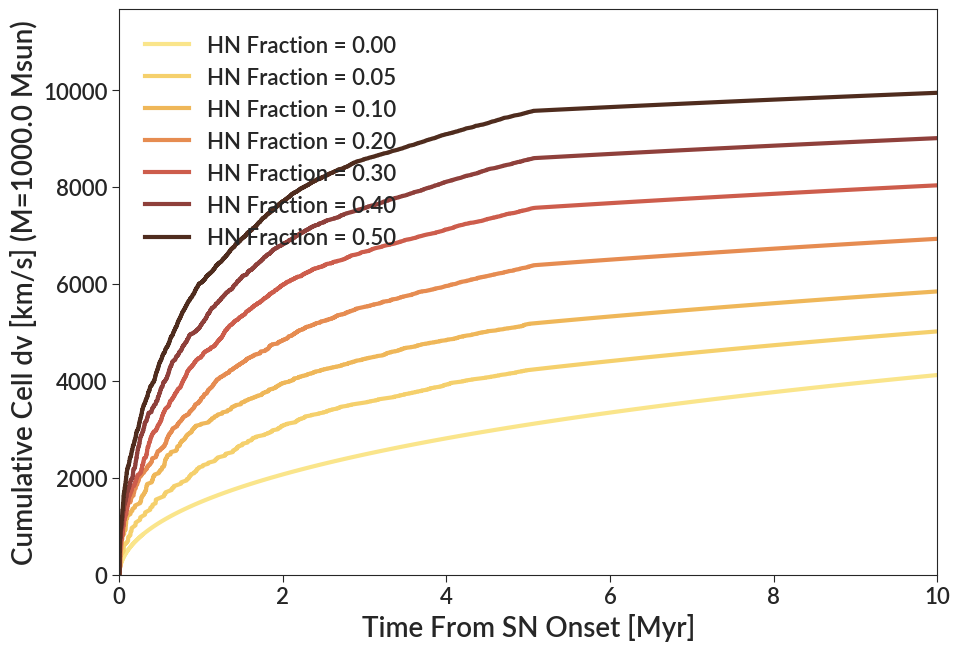

In [33]:
cell_mass = 1e3 * u.Msun

fig, ax = bpl.subplots()
for f in hn_fractions:
    plot_times = times[0.02][1:] - lt.lifetime(50.0, 0.02)
    
    this_obj = histories[f]
    
    total_E = np.array(this_obj.cumulative_sn_ii["E"]) * u.erg
    
    cell_v = np.sqrt(2 * (total_E / 26) / cell_mass).to("km/s").value

    ax.plot(plot_times / 1E6, 
            cell_v, 
            c=f_color(f),
            label=f"HN Fraction = {f:.2f}")

ax.legend(frameon=False, fontsize=16)
ax.add_labels("Time From SN Onset [Myr]", f"Cumulative Cell dv [km/s] (M={cell_mass.to('Msun').value} Msun)")

ax.set_limits(0, 10, 0)